In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
pd.options.mode.chained_assignment = None
import geopandas as gpd
import squarify 
from api_key import api_key

In [4]:
path = './output/house_info.csv'
df = pd.read_csv(path)

In [5]:
# drop imported index column
df = df.drop(['Unnamed: 0'], axis=1)

## Exploration 

In [6]:
df.describe()

,price,beds,baths,size,zipcode
count,7.600000e+02,760.000000,760.000000,760.000000,760.000000
mean,9.996521e+05,3.425000,2.850000,2377.650000,75282.200000
std,3.694397e+06,1.243547,2.736303,2896.364876,366.469399
min,1.750000e+05,1.000000,1.000000,807.000000,75205.000000
25%,2.437500e+05,3.000000,2.000000,1558.500000,75215.500000
50%,3.522500e+05,3.000000,2.000000,1809.000000,75221.500000
75%,4.999248e+05,4.000000,3.000000,2265.750000,75232.000000
max,2.400000e+07,9.000000,19.000000,20000.000000,77568.000000


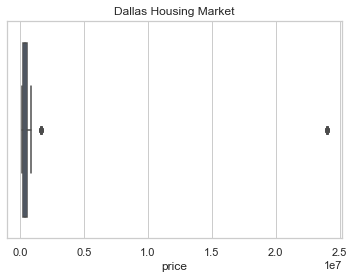

In [7]:
# Box plot to show distribution 
prices = df['price']
sns.set_theme(style="whitegrid")
ax = sns.boxplot(x=prices)
plt.title('Dallas Housing Market')
plt.show()

In [8]:
# remove extreme outliers
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1
houses = df[~((df < (Q1 - 1.5 * IQR)) |(df > (Q3 + 1.5 * IQR))).any(axis=1)]
print(f'Number of outliers: {len(df) - len(houses)}')

Number of outliers: 114


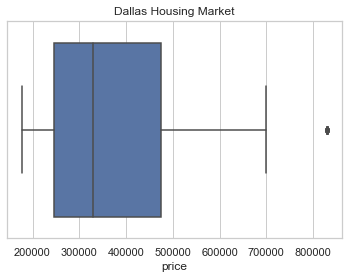

In [9]:
# boxplot without the outliers
prices = houses['price']
sns.set_theme(style="whitegrid")
ax = sns.boxplot(x=prices)
plt.title('Dallas Housing Market')
plt.show()

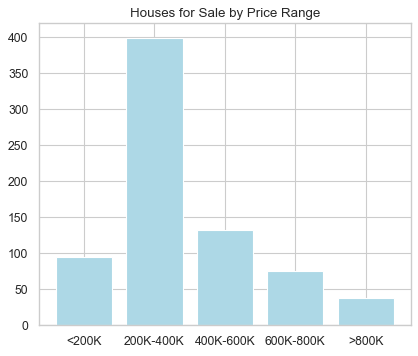

In [10]:
# Create bins for spending ranges and respective labels 
price_ranges = [0, 200000, 400000, 600000, 800000, 2000000]
spending_ranges = ["<200K", "200K-400K", "400K-600K", "600K-800K", ">800K"]
df['spending ranges'] = pd.cut(df["price"], price_ranges, labels=spending_ranges, include_lowest=False)

# count how many in each bin
count = df.groupby('spending ranges')['address'].count()

# plot
plt.figure(figsize=(6,5), dpi= 80)
plt.bar(spending_ranges, count, color='lightblue')
plt.title('Houses for Sale by Price Range')
plt.savefig('./output/price_range.png')
plt.show()

In [11]:
# Most expensive zip codes 
spending_zipcodes = pd.pivot_table(df, index=['spending ranges','zipcode'], values=['size', 'baths', 'beds'])

# formatting to make it prettier 
spending_zipcodes['beds'] = spending_zipcodes['beds'].map("{:.0f}".format)
spending_zipcodes['baths'] = spending_zipcodes['baths'].map("{:.0f}".format)
spending_zipcodes['size'] = spending_zipcodes['size'].map("{:.0f}".format)

spending_zipcodes

baths beds  size
spending ranges zipcode                 
<200K           75216       2    3  1262
                75217       2    4  1302
                75232       2    3  1602
                75241       3    4  1578
                75252       2    1   807
200K-400K       75205       2    1   869
                75208       2    2  1122
                75211       2    3  1600
                75212       2    4  1804
                75216       2    4  2300
                75217       3    4  2482
                75218       2    3  1500
                75224       2    4  1810
                75227       2    4  2200
                75229       2    4  2151
                75232       2    4  2030
                75236       2    4  2067
                75243       3    4  2463
                75249       2    3  1902
                75253       2    3  1441
400K-600K       75218       2    4  2088
                75223       2    2  1444
                75229       3    3  2042
                75231       2    3  2089
                75238       2    3  1647
                77568       4    4  3238
600K-800K       75206       5    4  2811
                75218       3    3  1712
                75223       2    3  1814
                75229       3    3  2491
>800K           75209       6    5  4403
                75214       2    3  1804

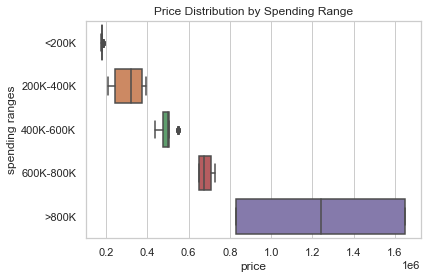

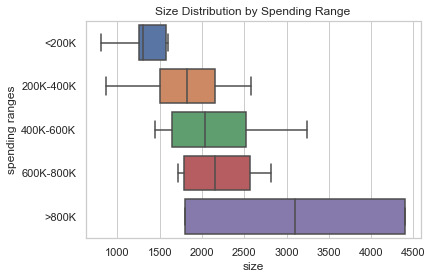

In [12]:
# df_spending = df.loc[df['spending ranges'] != '>800K']

# Boxplot of price by spending range
ax = sns.boxplot(x="price", y="spending ranges", data=df)
sns.set_theme(style="whitegrid")
plt.title('Price Distribution by Spending Range')
plt.show()

# Size by spending range 
ax = sns.boxplot(x="size", y="spending ranges", data=df)
sns.set_theme(style="whitegrid")
plt.title('Size Distribution by Spending Range')
plt.show()


In [125]:
# api_key = api_key ##from config file
# url = 'http://api.positionstack.com/v1/forward?'

# for i, row in houses.iterrows():
#     address = row['address']
#     query = url + "access_key=" + api_key + '&query=' + address
#     try:
#         response = requests.get(query).json()
#         houses.loc[i,'lat'] = response['data'][0]['latitude']
#         houses.loc[i,'lng'] = response['data'][0]['longitude']
#     except:
#         pass

In [42]:
## Save as csv to avoid running the api again
# houses.to_csv('./output/houses.csv')

# If restarting kernel run:
houses = pd.read_csv('./output/houses.csv')

### Plot on geomap

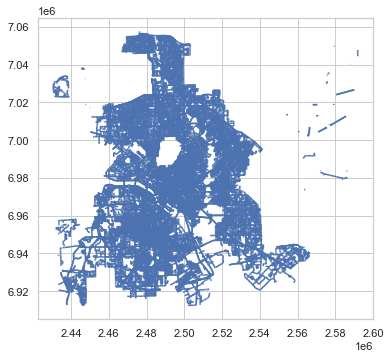

In [56]:
dallasMap = gpd.read_file('./streets/streets.shp')
dallasMap.plot(figsize=(6,6))
plt.show()

In [ ]:
# Plot heatmap/color-coded scatter plot grouped by price 



### Biggest house you can buy for each budget 


In [14]:
by_budget = df.groupby('spending ranges')['size'].max()
by_budget = pd.DataFrame(
    {'Largest house': by_budget}
)
by_budget

,Largest house
spending ranges,
<200K,1602
200K-400K,2582
400K-600K,3238
600K-800K,2811
>800K,4403


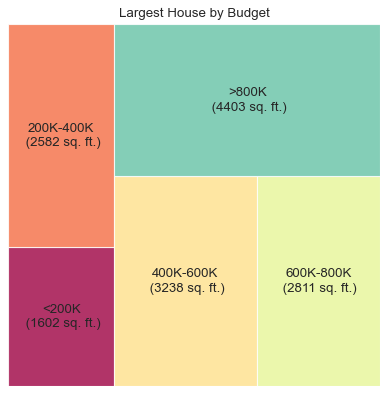

In [37]:
# Sizes
sizes = by_budget['Largest house']
budget = by_budget.reset_index() # To apply labels 
labels = budget.apply(lambda x: str(x[0]) + "\n (" + str(x[1]) + " sq. ft." + ")", axis=1)
colors = [plt.cm.Spectral(i/float(len(labels))) for i in range(len(labels))]

# Draw Plot
plt.figure(figsize=(6,6), dpi= 80)
squarify.plot(sizes=sizes, label=labels, color=colors, alpha=.8)

# Formatting
plt.title('Largest House by Budget')
plt.axis('off')
plt.show()

### Cost per square foot

In [39]:
# Calculate cost per square foot 
price_sqft = df.price / df.size
df['price per sqft'] = price_sqft

# Avg size by spending range 
avg_size = df.groupby('spending ranges')['size'].mean().round()

# Average price per square foot by spending range 
budget_sqft = df.groupby('spending ranges')['price per sqft'].mean()
budget_sqft = pd.DataFrame(budget_sqft)
budget_sqft['avg size'] = avg_size
budget_sqft

,price per sqft,avg size
spending ranges,,
<200K,23.755474,1310.0
200K-400K,40.276253,1852.0
400K-600K,64.807970,2091.0
600K-800K,89.736842,2207.0
>800K,163.125000,3104.0
